####  Connect to the database where the .csv data file has been imported as a table

In [1]:
import sqlite3
from sqlite3 import Error


def connection(db_file):
    """ create a database connection to the SQLite database specified
    by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connection('../data/input/chinook.db')

#### What is the most common channel for acquiring users? What is the second most common channel for acquiring users?

In [2]:
def get_top_n_acquirers(conn, n):
    """
    Selects most successful acquirer channels
    :param conn: connection object
    :param n: number of elements in ranking, descending
    :return:
    """
    cur = conn.cursor()
    cur.execute(
        f"""SELECT user_channel AS channel,
        count(user_id) AS number_users
        FROM taxfix
        GROUP BY user_channel
        ORDER BY number_users DESC 
        LIMIT {n}"""
    )

    rows = cur.fetchall()

    for i, j in enumerate(rows):
        print(f"'{j[0]}' is the {i+1} channel with {j[1]} users acquired")

    return None


#Execute the previously defined function
get_top_n_acquirers(conn, 2)

'organic' is the 1 channel with 9303 users acquired
'uac' is the 2 channel with 5587 users acquired


#### How much time does it usually take for a user from their registration to submit their tax declaration?

In [3]:
def get_avg_submission_time(conn):
    """
    Selects and prints the average time a user takes to submit their tax
    declaration since they registered
    :param conn: connection object
    :return: integer of number of average days
    """
    cur = conn.cursor()
    cur.execute(
        f"""with dates as 
        (
        select
        user_id,
        datetime(substr(submission_date, 7, 4) || '-' || substr(submission_date, 4, 2) || '-' || substr(submission_date, 1, 2) || ' ' || substr(submission_date, 12, 2) || ':' || substr(submission_date, 15, 2) || ':' || substr(submission_date, 18, 2)) as sub_date,
        datetime(substr(registration_date , 7, 4) || '-' || substr(registration_date , 4, 2) || '-' || substr(registration_date , 1, 2) || ' ' || substr(registration_date, 12, 2) || ':' || substr(registration_date, 15, 2) || ':' || substr(registration_date, 18, 2)) as reg_date
        from taxfix
        where submission_date is not null
        )
        select 
        round((avg(STRFTIME('%s' ,sub_date) - STRFTIME('%s' ,reg_date))) * 1.0 / 60 / 24) as avg_time
        from dates"""
    )

    row = cur.fetchall()
    days = int(row[0][0])

    print(
        f"Average time a user took to complete their tax submission "
        f"since the registered was {days} days"
    )

    return days


#Execute the previously defined function and assign the value to variable for later user in visualization.
avg_time = get_avg_submission_time(conn)

Average time a user took to complete their tax submission since the registered was 30 days


#### Include a data visualization

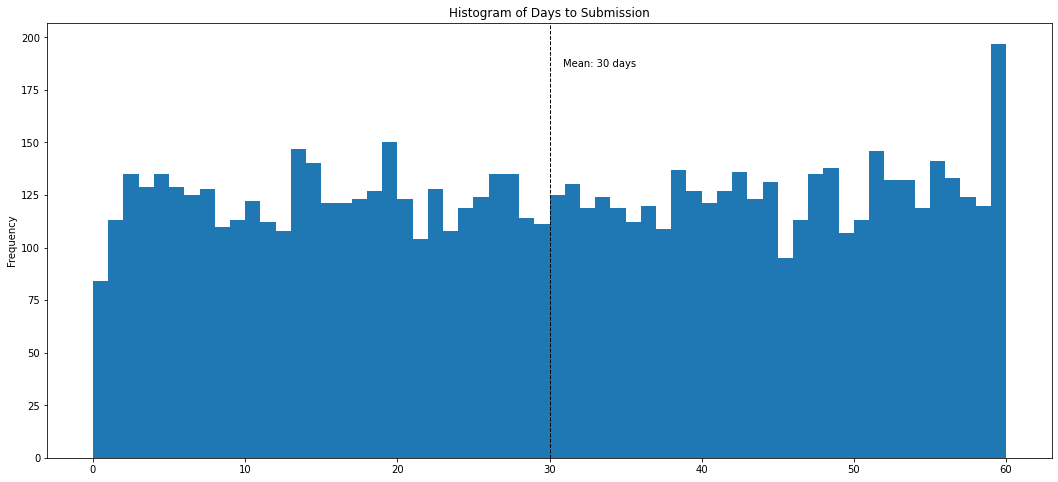

In [4]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt


def get_submission_time_user(conn):
    """
    Provides list user, submission and registration dates, and difference
    :param conn: connection object
    :return:list
    """

    cur = conn.cursor()
    cur.execute(
        f"""with dates as 
        (
        select
        user_id,
        datetime(substr(submission_date, 7, 4) || '-' || substr(submission_date, 4, 2) || '-' || substr(submission_date, 1, 2) || ' ' || substr(submission_date, 12, 2) || ':' || substr(submission_date, 15, 2) || ':' || substr(submission_date, 18, 2)) as sub_date,
        datetime(substr(registration_date , 7, 4) || '-' || substr(registration_date , 4, 2) || '-' || substr(registration_date , 1, 2) || ' ' || substr(registration_date, 12, 2) || ':' || substr(registration_date, 15, 2) || ':' || substr(registration_date, 18, 2)) as reg_date
        from taxfix
        where submission_date is not null
        )
        select 
        user_id,
        sub_date,
        reg_date,
        round((STRFTIME('%s' ,sub_date) - STRFTIME('%s' ,reg_date))*1.0 / 60 / 24) as difference
        from dates
        order by difference DESC"""
    )

    rows = cur.fetchall()

    return rows


def create_df(timings_list):

    data = timings_list
    cols = ['user', 'submission_time', 'registration_time', 'days_difference']
    df_user_timings = pd.DataFrame(data, columns=cols)
    df_user_timings['user'] = df_user_timings['user'].astype('category')

    return df_user_timings


def create_viz(df, constant):
    
    mean_days = constant

    series_user_timing = df['days_difference']
    #print(series_user_timing.describe())
    data_viz = series_user_timing.plot.hist(
        bins=60, figsize=(18, 8), xlabel='days', title='Histogram of Days to Submission'
    )
    #Plot mean dashed line
    data_viz.axvline(mean_days, color='k', linestyle='dashed', linewidth=1)
    
    #Add text to line
    min_ylim, max_ylim = plt.ylim()
    data_viz.text(mean_days*1.03, max_ylim*0.9, f'Mean: {mean_days} days')
    
    #Export viz to .png file
    data_viz.figure.savefig("../data/output/avg_sub_time_user_2.png", facecolor='w')
    
    return None


#Execute previously defined function
user_timings = get_submission_time_user(conn)
df_user_timings = create_df(user_timings)
create_viz(df_user_timings, avg_time)